# GM-VAE for SMBA

In [1]:
num_components=3

## Import Libraries

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
from metrics.Metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [125]:
mario_chunks_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')
icarus_chunks_int = open_json_as_nparray('kiWithPath-allLevels-chunks-int.json')
megaman_chunks_int = open_json_as_nparray('./megaman_with_path_chunks_int.json')

chunks_int = np.concatenate([mario_chunks_int, icarus_chunks_int, megaman_chunks_int])
labels = np.concatenate([
    np.zeros(mario_chunks_int.shape[0]), 
    np.ones(icarus_chunks_int.shape[0]),
    np.ones(megaman_chunks_int.shape[0]) * 2,
]).astype(int)

chunks_onehot = np.eye(len(np.unique(chunks_int)))[chunks_int]
chunks = chunks_onehot

## Input Parameters

In [5]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=4352, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [6]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [7]:
from torch.utils.data import TensorDataset, DataLoader

In [8]:
valid_indices = np.random.randint(len(chunks), size=500)
train_chunks, valid_chunks = chunks, chunks[valid_indices]
train_labels, valid_labels = labels, labels[valid_indices]

train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

In [9]:
frequency = np.bincount(labels)

In [10]:
# train_sampler = WeightedRandomSampler(1 / frequency[labels], num_samples=len(train_chunks), replacement=True)

# train_dl = DataLoader(train_ds, batch_size=64, sampler=train_sampler)
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)

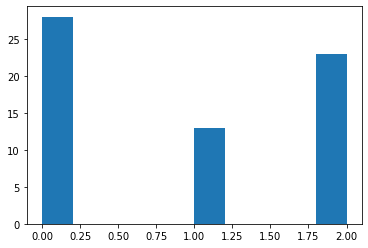

In [11]:
plt.hist(next(iter(train_dl))[1].numpy())
plt.show()

## Train Model

In [12]:
# Model Initialization
gmvae = GMVAE(args)

In [79]:

# history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 100) Train_Loss: 630.140; Val_Loss: 400.874   Train_ACC: 73.612; Val_ACC: 100.000   Train_NMI: 37.801; Val_NMI: 100.000
(Epoch 2 / 100) Train_Loss: 371.399; Val_Loss: 367.128   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3 / 100) Train_Loss: 344.191; Val_Loss: 349.672   Train_ACC: 99.972; Val_ACC: 100.000   Train_NMI: 99.787; Val_NMI: 100.000
(Epoch 4 / 100) Train_Loss: 330.090; Val_Loss: 339.318   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5 / 100) Train_Loss: 321.116; Val_Loss: 327.311   Train_ACC: 99.930; Val_ACC: 100.000   Train_NMI: 99.529; Val_NMI: 100.000
(Epoch 6 / 100) Train_Loss: 312.651; Val_Loss: 319.446   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7 / 100) Train_Loss: 304.295; Val_Loss: 311.213   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8 / 100) Train_Loss: 295.219; Val_Loss: 306.220   Train_ACC: 100.000

(Epoch 63 / 100) Train_Loss: 173.663; Val_Loss: 179.126   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 64 / 100) Train_Loss: 173.183; Val_Loss: 178.589   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 65 / 100) Train_Loss: 171.646; Val_Loss: 178.728   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 66 / 100) Train_Loss: 170.542; Val_Loss: 176.529   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 67 / 100) Train_Loss: 170.687; Val_Loss: 174.035   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 68 / 100) Train_Loss: 170.237; Val_Loss: 173.188   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 69 / 100) Train_Loss: 166.183; Val_Loss: 172.499   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 70 / 100) Train_Loss: 167.802; Val_Loss: 173.620   Trai

In [80]:
# torch.save(gmvae.network.state_dict(), 'smba_gmvae_3games.pth')

In [13]:
gmvae.network.load_state_dict(torch.load('smba_gmvae_3games.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Image Reconstruction

In [18]:
original, reconstructed = gmvae.reconstruct_data(train_dl, 15)  

In [19]:
original_int = original.reshape(15, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 12).argmax(axis=-1)

In [20]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [21]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [22]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [23]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

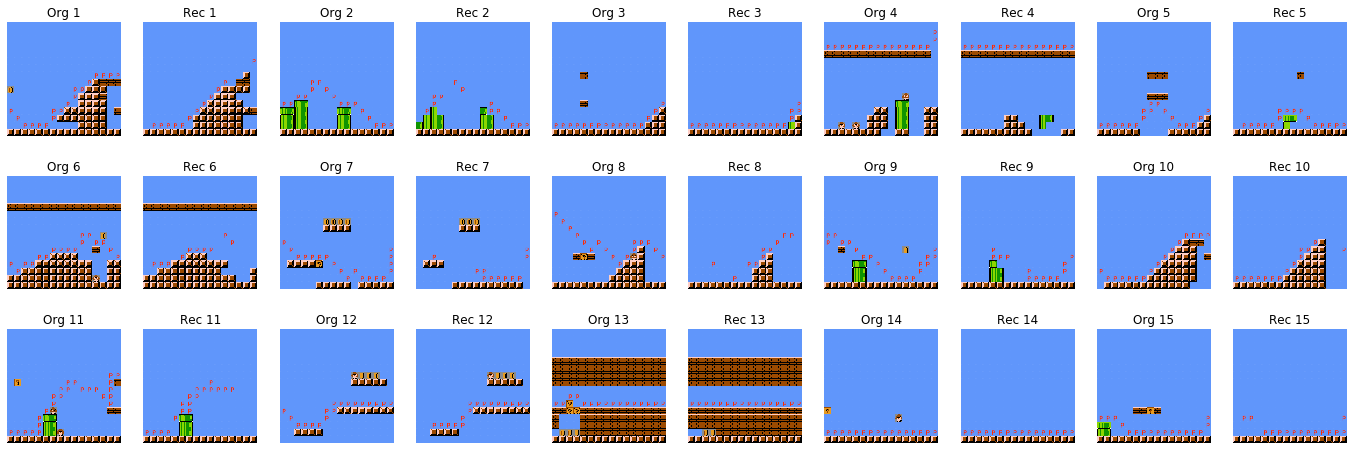

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

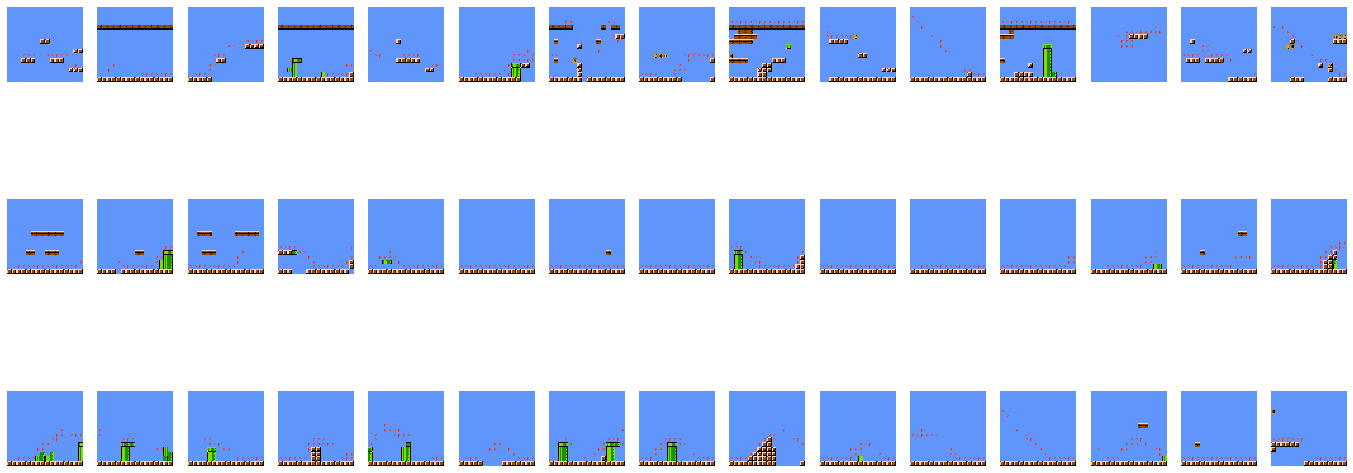

In [81]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,10])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 15
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [26]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [27]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [28]:
generated_int.shape

(9999, 16, 16)

In [29]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations_2_to_7/smba_gmvae_{num_components}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [14]:
test_features, test_labels = gmvae.latent_features(DataLoader(train_ds, batch_size=64, shuffle=False), return_learned_labels=True)

In [61]:
assert len(test_features) - len(mario_chunks_int) - len(icarus_chunks_int) - len(megaman_chunks_int) == 0

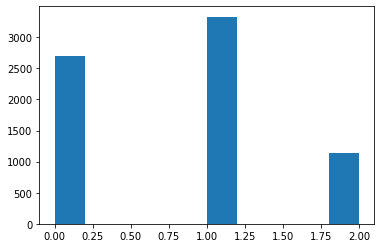

In [15]:
plt.hist(test_labels)
plt.show()

In [70]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

random_idxs = np.random.randint(len(test_features), size=1000)
tsne_features = TSNE(n_components=2).fit_transform(test_features[random_idxs])

In [71]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

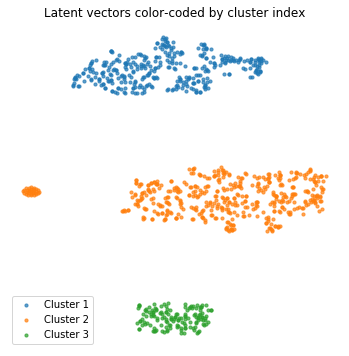

In [72]:
plt.figure(figsize=(6, 6))

for i in range(3):
    
    plt.scatter(
        tsne_features[test_labels[random_idxs] == i][X_], 
        tsne_features[test_labels[random_idxs] == i][Y_],
        s=10, alpha=0.7,
        label=f'Cluster {i+1}'
    )
    
plt.axis('off')
plt.legend()
plt.title('Latent vectors color-coded by cluster index')
plt.savefig('3 game latent vectors color-coded by cluster index (GM-VAE).png', dpi=100)

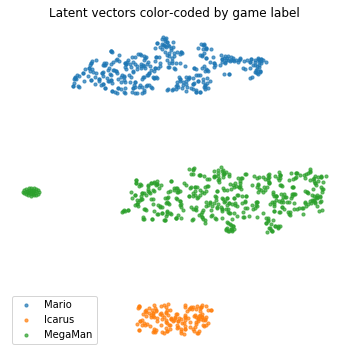

In [75]:
plt.figure(figsize=(6, 6))

level_types = ['Mario', 'Icarus', 'MegaMan']

for i in range(3):

    plt.scatter(
        tsne_features[labels[random_idxs] == i][X_], 
        tsne_features[labels[random_idxs] == i][Y_],  
        label=level_types[i],
        s=10, alpha=0.7
    )
            
plt.axis('off')
plt.legend()
plt.title('Latent vectors color-coded by game label')
plt.savefig('3 game latent vectors color-coded by game label (GM-VAE).png', dpi=100)

In [76]:
metrics = Metrics()
metrics.cluster_acc(test_labels[:first_n], labels[:first_n])

1.0

## Investigate the small blob

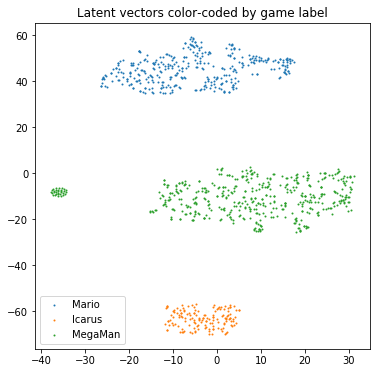

In [115]:
plt.figure(figsize=(6, 6))

level_types = ['Mario', 'Icarus', 'MegaMan']

for i in range(3):

    plt.scatter(
        tsne_features[labels[random_idxs] == i][X_], 
        tsne_features[labels[random_idxs] == i][Y_],  
        label=level_types[i],
        s=1, alpha=1
    )
            
plt.legend()
plt.title('Latent vectors color-coded by game label')
plt.savefig('3 game latent vectors color-coded by game label (GM-VAE).png', dpi=100)

In [79]:
chunks_int[random_idxs][tsne_features[X_] < -30][0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [110]:
idxs_3games = random_idxs[tsne_features[X_] < -30]
idxs_3games, len(idxs_3games)

(array([5655, 6664, 5431, 4619, 5754, 5977, 4022, 6695, 5499, 5650, 5365,
        5382, 6886, 5817, 5934, 7029, 4632, 4578, 6564, 6925, 4007, 6795,
        5652, 4997, 6684, 5185, 6614, 5209, 6151, 5332, 4281]), 31)

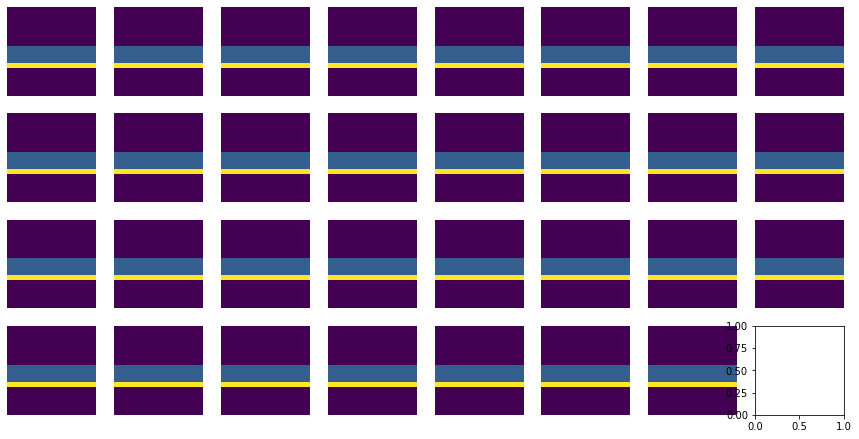

In [122]:
fig, axs = plt.subplots(4, len(idxs_3games) // 4 + 1, figsize=(15, 7.5))
axs = axs.flatten()
for idx, i in enumerate(idxs_3games):
    axs[idx].matshow(chunks_int[i])
    axs[idx].axis('off')
plt.show()

In [123]:
idxs_megaman = idxs_3games - len(mario_chunks_int) - len(icarus_chunks_int)
idxs_megaman

array([1815, 2824, 1591,  779, 1914, 2137,  182, 2855, 1659, 1810, 1525,
       1542, 3046, 1977, 2094, 3189,  792,  738, 2724, 3085,  167, 2955,
       1812, 1157, 2844, 1345, 2774, 1369, 2311, 1492,  441])

In [124]:
idxs_megaman, len(idxs_megaman)

(array([1815, 2824, 1591,  779, 1914, 2137,  182, 2855, 1659, 1810, 1525,
        1542, 3046, 1977, 2094, 3189,  792,  738, 2724, 3085,  167, 2955,
        1812, 1157, 2844, 1345, 2774, 1369, 2311, 1492,  441]), 31)